<a href="https://colab.research.google.com/github/grosetta/rdkit_study/blob/main/xyz2mol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#文件头代码
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.insert(0,"/content/drive/My Drive/Colab Notebooks/python_package/")

Mounted at /content/drive


In [ ]:
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
 
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

# mol2svg相关函数

In [ ]:
def moltosvg(mol,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg
 
def render_svg(svg):
    return SVG(svg.replace('svg:',''))

# xyz2mol 相关函数

In [ ]:
"""
https://github.com/jensengroup/xyz2mol/blob/master/xyz2mol.py
"""
##
# Written by Jan H. Jensen based on this paper Yeonjoon Kim and Woo Youn Kim
# "Universal Structure Conversion Method for Organic Molecules: From Atomic Connectivity
# to Three-Dimensional Geometry" Bull. Korean Chem. Soc. 2015, Vol. 36, 1769-1777 DOI: 10.1002/bkcs.10334
#
from rdkit import Chem
from rdkit.Chem import AllChem
import itertools
from rdkit.Chem import rdmolops
from collections import defaultdict
import copy
import networkx as nx  # uncomment if you don't want to use "quick"/install networkx
 
global __ATOM_LIST__
__ATOM_LIST__ = [x.strip() for x in ['h ', 'he', \
                                     'li', 'be', 'b ', 'c ', 'n ', 'o ', 'f ', 'ne', \
                                     'na', 'mg', 'al', 'si', 'p ', 's ', 'cl', 'ar', \
                                     'k ', 'ca', 'sc', 'ti', 'v ', 'cr', 'mn', 'fe', 'co', 'ni', 'cu', \
                                     'zn', 'ga', 'ge', 'as', 'se', 'br', 'kr', \
                                     'rb', 'sr', 'y ', 'zr', 'nb', 'mo', 'tc', 'ru', 'rh', 'pd', 'ag', \
                                     'cd', 'in', 'sn', 'sb', 'te', 'i ', 'xe', \
                                     'cs', 'ba', 'la', 'ce', 'pr', 'nd', 'pm', 'sm', 'eu', 'gd', 'tb', 'dy', \
                                     'ho', 'er', 'tm', 'yb', 'lu', 'hf', 'ta', 'w ', 're', 'os', 'ir', 'pt', \
                                     'au', 'hg', 'tl', 'pb', 'bi', 'po', 'at', 'rn', \
                                     'fr', 'ra', 'ac', 'th', 'pa', 'u ', 'np', 'pu']]
 
 
def get_atom(atom):
    global __ATOM_LIST__
    atom = atom.lower()
    return __ATOM_LIST__.index(atom) + 1
 
 
def getUA(maxValence_list, valence_list):
    UA = []
    DU = []
    for i, (maxValence, valence) in enumerate(zip(maxValence_list, valence_list)):
        if maxValence - valence > 0:
            UA.append(i)
            DU.append(maxValence - valence)
    return UA, DU
 
 
def get_BO(AC, UA, DU, valences, UA_pairs, quick):
    BO = AC.copy()
    DU_save = []
 
    while DU_save != DU:
        for i, j in UA_pairs:
            BO[i, j] += 1
            BO[j, i] += 1
 
        BO_valence = list(BO.sum(axis=1))
        DU_save = copy.copy(DU)
        UA, DU = getUA(valences, BO_valence)
        UA_pairs = get_UA_pairs(UA, AC, quick)[0]
 
    return BO
 
 
def valences_not_too_large(BO, valences):
    number_of_bonds_list = BO.sum(axis=1)
    for valence, number_of_bonds in zip(valences, number_of_bonds_list):
        if number_of_bonds > valence:
            return False
 
    return True
 
 
def BO_is_OK(BO, AC, charge, DU, atomic_valence_electrons, atomicNumList, charged_fragments):
    Q = 0  # total charge
    q_list = []
    if charged_fragments:
        BO_valences = list(BO.sum(axis=1))
        for i, atom in enumerate(atomicNumList):
            q = get_atomic_charge(atom, atomic_valence_electrons[atom], BO_valences[i])
            Q += q
            if atom == 6:
                number_of_single_bonds_to_C = list(BO[i, :]).count(1)
                if number_of_single_bonds_to_C == 2 and BO_valences[i] == 2:
                    Q += 1
                    q = 2
                if number_of_single_bonds_to_C == 3 and Q + 1 < charge:
                    Q += 2
                    q = 1
 
            if q != 0:
                q_list.append(q)
 
    if (BO - AC).sum() == sum(DU) and charge == Q and len(q_list) <= abs(charge):
        return True
    else:
        return False
 
 
def get_atomic_charge(atom, atomic_valence_electrons, BO_valence):
    if atom == 1:
        charge = 1 - BO_valence
    elif atom == 5:
        charge = 3 - BO_valence
    elif atom == 15 and BO_valence == 5:
        charge = 0
    elif atom == 16 and BO_valence == 6:
        charge = 0
    else:
        charge = atomic_valence_electrons - 8 + BO_valence
 
    return charge
 
 
def clean_charges(mol):
    # this hack should not be needed any more but is kept just in case
    #
 
    rxn_smarts = ['[N+:1]=[*:2]-[C-:3]>>[N+0:1]-[*:2]=[C-0:3]',
                  '[N+:1]=[*:2]-[O-:3]>>[N+0:1]-[*:2]=[O-0:3]',
                  '[N+:1]=[*:2]-[*:3]=[*:4]-[O-:5]>>[N+0:1]-[*:2]=[*:3]-[*:4]=[O-0:5]',
                  '[#8:1]=[#6:2]([!-:6])[*:3]=[*:4][#6-:5]>>[*-:1][*:2]([*:6])=[*:3][*:4]=[*+0:5]',
                  '[O:1]=[c:2][c-:3]>>[*-:1][*:2][*+0:3]',
                  '[O:1]=[C:2][C-:3]>>[*-:1][*:2]=[*+0:3]']
 
    fragments = Chem.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
 
    for i, fragment in enumerate(fragments):
        for smarts in rxn_smarts:
            patt = Chem.MolFromSmarts(smarts.split(">>")[0])
            while fragment.HasSubstructMatch(patt):
                rxn = AllChem.ReactionFromSmarts(smarts)
                ps = rxn.RunReactants((fragment,))
                fragment = ps[0][0]
        if i == 0:
            mol = fragment
        else:
            mol = Chem.CombineMols(mol, fragment)
 
    return mol
 
 
def BO2mol(mol, BO_matrix, atomicNumList, atomic_valence_electrons, mol_charge, charged_fragments):
    # based on code written by Paolo Toscani
 
    l = len(BO_matrix)
    l2 = len(atomicNumList)
    BO_valences = list(BO_matrix.sum(axis=1))
 
    if (l != l2):
        raise RuntimeError('sizes of adjMat ({0:d}) and atomicNumList '
                           '{1:d} differ'.format(l, l2))
 
    rwMol = Chem.RWMol(mol)
 
    bondTypeDict = {
        1: Chem.BondType.SINGLE,
        2: Chem.BondType.DOUBLE,
        3: Chem.BondType.TRIPLE
    }
 
    for i in range(l):
        for j in range(i + 1, l):
            bo = int(round(BO_matrix[i, j]))
            if (bo == 0):
                continue
            bt = bondTypeDict.get(bo, Chem.BondType.SINGLE)
            rwMol.AddBond(i, j, bt)
    mol = rwMol.GetMol()
 
    if charged_fragments:
        mol = set_atomic_charges(mol, atomicNumList, atomic_valence_electrons, BO_valences, BO_matrix, mol_charge)
    else:
        mol = set_atomic_radicals(mol, atomicNumList, atomic_valence_electrons, BO_valences)
 
    return mol
 
 
def set_atomic_charges(mol, atomicNumList, atomic_valence_electrons, BO_valences, BO_matrix, mol_charge):
    q = 0
    for i, atom in enumerate(atomicNumList):
        a = mol.GetAtomWithIdx(i)
        charge = get_atomic_charge(atom, atomic_valence_electrons[atom], BO_valences[i])
        q += charge
        if atom == 6:
            number_of_single_bonds_to_C = list(BO_matrix[i, :]).count(1)
            if number_of_single_bonds_to_C == 2 and BO_valences[i] == 2:
                q += 1
                charge = 0
            if number_of_single_bonds_to_C == 3 and q + 1 < mol_charge:
                q += 2
                charge = 1
 
        if (abs(charge) > 0):
            a.SetFormalCharge(int(charge))
 
    # shouldn't be needed anymore bit is kept just in case
    # mol = clean_charges(mol)
 
    return mol
 
 
def set_atomic_radicals(mol, atomicNumList, atomic_valence_electrons, BO_valences):
    # The number of radical electrons = absolute atomic charge
    for i, atom in enumerate(atomicNumList):
        a = mol.GetAtomWithIdx(i)
        charge = get_atomic_charge(atom, atomic_valence_electrons[atom], BO_valences[i])
 
        if (abs(charge) > 0):
            a.SetNumRadicalElectrons(abs(int(charge)))
 
    return mol
 
 
def get_bonds(UA, AC):
    bonds = []
 
    for k, i in enumerate(UA):
        for j in UA[k + 1:]:
            if AC[i, j] == 1:
                bonds.append(tuple(sorted([i, j])))
 
    return bonds
 
 
def get_UA_pairs(UA, AC, quick):
    bonds = get_bonds(UA, AC)
    if len(bonds) == 0:
        return [()]
 
    if quick:
        G = nx.Graph()
        G.add_edges_from(bonds)
        UA_pairs = [list(nx.max_weight_matching(G))]
        return UA_pairs
 
    max_atoms_in_combo = 0
    UA_pairs = [()]
    for combo in list(itertools.combinations(bonds, int(len(UA) / 2))):
        flat_list = [item for sublist in combo for item in sublist]
        atoms_in_combo = len(set(flat_list))
        if atoms_in_combo > max_atoms_in_combo:
            max_atoms_in_combo = atoms_in_combo
            UA_pairs = [combo]
        #           if quick and max_atoms_in_combo == 2*int(len(UA)/2):
        #               return UA_pairs
        elif atoms_in_combo == max_atoms_in_combo:
            UA_pairs.append(combo)
 
    return UA_pairs
 
 
def AC2BO(AC, atomicNumList, charge, charged_fragments, quick):
    # TODO
    atomic_valence = defaultdict(list)
    atomic_valence[1] = [1]
    atomic_valence[6] = [4]
    atomic_valence[7] = [4, 3]
    atomic_valence[8] = [2, 1]
    atomic_valence[9] = [1]
    atomic_valence[14] = [4]
    atomic_valence[15] = [5, 4, 3]
    atomic_valence[16] = [6, 4, 2]
    atomic_valence[17] = [1]
    atomic_valence[32] = [4]
    atomic_valence[35] = [1]
    atomic_valence[53] = [1]
 
    atomic_valence_electrons = {}
    atomic_valence_electrons[1] = 1
    atomic_valence_electrons[6] = 4
    atomic_valence_electrons[7] = 5
    atomic_valence_electrons[8] = 6
    atomic_valence_electrons[9] = 7
    atomic_valence_electrons[14] = 4
    atomic_valence_electrons[15] = 5
    atomic_valence_electrons[16] = 6
    atomic_valence_electrons[17] = 7
    atomic_valence_electrons[32] = 4
    atomic_valence_electrons[35] = 7
    atomic_valence_electrons[53] = 7
 
    # make a list of valences, e.g. for CO: [[4],[2,1]]
    valences_list_of_lists = []
    for atomicNum in atomicNumList:
        valences_list_of_lists.append(atomic_valence[atomicNum])
 
    # convert [[4],[2,1]] to [[4,2],[4,1]]
    valences_list = list(itertools.product(*valences_list_of_lists))
 
    best_BO = AC.copy()
 
    # implemenation of algorithm shown in Figure 2
    # UA: unsaturated atoms
    # DU: degree of unsaturation (u matrix in Figure)
    # best_BO: Bcurr in Figure
    #
 
    for valences in valences_list:
        AC_valence = list(AC.sum(axis=1))
        UA, DU_from_AC = getUA(valences, AC_valence)
 
        if len(UA) == 0 and BO_is_OK(AC, AC, charge, DU_from_AC, atomic_valence_electrons, atomicNumList,
                                     charged_fragments):
            return AC, atomic_valence_electrons
 
        UA_pairs_list = get_UA_pairs(UA, AC, quick)
        for UA_pairs in UA_pairs_list:
            BO = get_BO(AC, UA, DU_from_AC, valences, UA_pairs, quick)
            if BO_is_OK(BO, AC, charge, DU_from_AC, atomic_valence_electrons, atomicNumList, charged_fragments):
                return BO, atomic_valence_electrons
 
            elif BO.sum() >= best_BO.sum() and valences_not_too_large(BO, valences):
                best_BO = BO.copy()
 
    return best_BO, atomic_valence_electrons
 
 
def AC2mol(mol, AC, atomicNumList, charge, charged_fragments, quick):
    # convert AC matrix to bond order (BO) matrix
    BO, atomic_valence_electrons = AC2BO(AC, atomicNumList, charge, charged_fragments, quick)
 
    # add BO connectivity and charge info to mol object
    mol = BO2mol(mol, BO, atomicNumList, atomic_valence_electrons, charge, charged_fragments)
 
    return mol
 
 
def get_proto_mol(atomicNumList):
    mol = Chem.MolFromSmarts("[#" + str(atomicNumList[0]) + "]")
    rwMol = Chem.RWMol(mol)
    for i in range(1, len(atomicNumList)):
        a = Chem.Atom(atomicNumList[i])
        rwMol.AddAtom(a)
 
    mol = rwMol.GetMol()
 
    return mol
 
 
def get_atomicNumList(atomic_symbols):
    atomicNumList = []
    for symbol in atomic_symbols:
        atomicNumList.append(get_atom(symbol))
    return atomicNumList
 
 
def read_xyz_file(filename):
    atomic_symbols = []
    xyz_coordinates = []
 
    with open(filename, "r") as file:
        for line_number, line in enumerate(file):
            if line_number == 0:
                num_atoms = int(line)
            elif line_number == 1:
                if "charge=" in line:
                    charge = int(line.split("=")[1])
                else:
                    charge = 0
            else:
                atomic_symbol, x, y, z = line.split()
                atomic_symbols.append(atomic_symbol)
                xyz_coordinates.append([float(x), float(y), float(z)])
 
    atomicNumList = get_atomicNumList(atomic_symbols)
 
    return atomicNumList, charge, xyz_coordinates
 
 
def xyz2AC(atomicNumList, xyz):
    import numpy as np
    mol = get_proto_mol(atomicNumList)
 
    conf = Chem.Conformer(mol.GetNumAtoms())
    for i in range(mol.GetNumAtoms()):
        conf.SetAtomPosition(i, (xyz[i][0], xyz[i][1], xyz[i][2]))
    mol.AddConformer(conf)
 
    dMat = Chem.Get3DDistanceMatrix(mol)
    pt = Chem.GetPeriodicTable()
 
    num_atoms = len(atomicNumList)
    AC = np.zeros((num_atoms, num_atoms)).astype(int)
 
    for i in range(num_atoms):
        a_i = mol.GetAtomWithIdx(i)
        Rcov_i = pt.GetRcovalent(a_i.GetAtomicNum()) * 1.30
        for j in range(i + 1, num_atoms):
            a_j = mol.GetAtomWithIdx(j)
            Rcov_j = pt.GetRcovalent(a_j.GetAtomicNum()) * 1.30
            if dMat[i, j] <= Rcov_i + Rcov_j:
                AC[i, j] = 1
                AC[j, i] = 1
 
    return AC, mol
 
 
def chiral_stereo_check(mol):
    Chem.SanitizeMol(mol)
    Chem.DetectBondStereochemistry(mol, -1)
    Chem.AssignStereochemistry(mol, flagPossibleStereoCenters=True, force=True)
    Chem.AssignAtomChiralTagsFromStructure(mol, -1)
 
    return mol
 
 
def xyz2mol(atomicNumList, charge, xyz_coordinates, charged_fragments, quick):
    # Get atom connectivity (AC) matrix, list of atomic numbers, molecular charge,
    # and mol object with no connectivity information
    AC, mol = xyz2AC(atomicNumList, xyz_coordinates)
 
    # Convert AC to bond order matrix and add connectivity and charge info to mol object
    new_mol = AC2mol(mol, AC, atomicNumList, charge, charged_fragments, quick)
 
    # Check for stereocenters and chiral centers
    new_mol = chiral_stereo_check(new_mol)
 
    return new_mol

# xyz2mol对象函数

In [ ]:
def mol_from_xyz(filepath):
    charged_fragments = True  # alternatively radicals are made
 
    # quick is faster for large systems but requires networkx
    # if you don't want to install networkx set quick=False and
    # uncomment 'import networkx as nx' at the top of the file
    quick = True
 
    atomicNumList, charge, xyz_coordinates = read_xyz_file(filepath)
    mol = xyz2mol(atomicNumList, charge, xyz_coordinates, charged_fragments, quick)
 
    # Canonical hack
    smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
    m = Chem.MolFromSmiles(smiles)
    return m

# 绘图

In [ ]:
from glob import glob
xyz_filepath_list = list(glob('/content/drive/MyDrive/data/*.xyz'))
 
xyz_filepath_list.sort()
print('当前路径下共有xyz文件个数：', len(xyz_filepath_list))

当前路径下共有xyz文件个数： 1


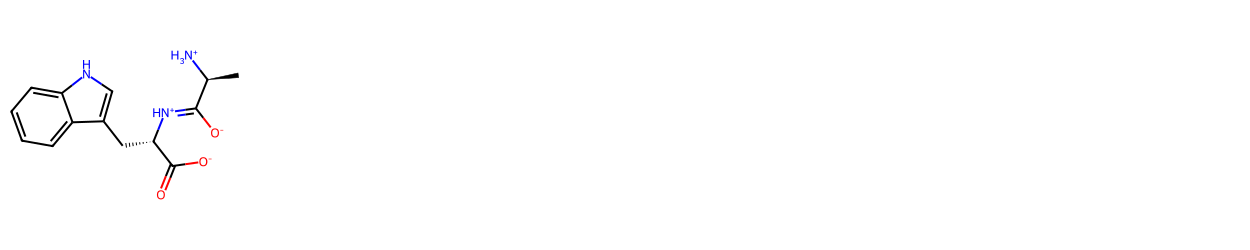

In [ ]:
num_mols = len(xyz_filepath_list)
 
mol_list = []
for i in range(num_mols):
    filepath = xyz_filepath_list[i]
    mol = mol_from_xyz(filepath)
    if mol is None:
        print(f'{i}-th file {filepath} failed, skip')
    mol_list.append(mol)
from rdkit.Chem import Draw
img = Draw.MolsToGridImage(mol_list, molsPerRow=5, subImgSize=(250, 250), maxMols=num_mols,
                           legends=None, useSVG=True)
 
img